# Convolutional Neural Network

### Contents
    1. Introduction
    2. Import Libraries
    3. CIFAR10 Dataset
    4. Build Convolutional Neural Network
    5. Train the Model
    6. Test the Model
    7. Save the Model

## 1. Introduction
**Convolutional Neural Network**, often abbreviated as **CNN**, is one variant of deep neural network, which is very effective in processing visual information. It typically consists of convolutional layers that extracts features from images, pooling layers that reduces the dimension of data, and fully connected layers that are used to classifies the images. <br/>
<br>The below image describes the aforementioned architecture. `Conv` layer and `pool` layer compose of feature extraction layers and fully connected layer performs classification.

![CNN_Architecture](./Images/CNN_Architecture.png)
[Image source](https://www.researchgate.net/figure/An-example-of-CNN-architecture_fig1_320748406)

The main characteristics of CNN follows;
* Maintain shape of input/output data of each layer
* Effectively recognize features of adjacent images while maintaining spatial information of the images
* Extract and learn features of an image with multiple filters
* Pooling layer to collect and enhace features of extracted images
* Filter used as a shared parameters, fewer parameters compared to general deep neural networks

The detailed information on CNN can be found at this [link](http://cs231n.github.io/convolutional-networks/)

## 2. Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils

import numpy as np
import os
import warnings
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
print(torch.__version__)

1.5.1+cpu


In [3]:
# CPU / GPU Setting
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## 3. Dataset with CIFAR10

It is provided by the University of Torronto and collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. Its total size is 163MB for python. Further information is provided to [this link](https://www.cs.toronto.edu/~kriz/cifar.html)

<img src = './Images/CIFAR10.png' width="600" height="600" align = "left">

In [4]:
# define a transform to normalize the data

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # converting images to tensor
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5)) 
    # if the image dataset is black and white image, there can be just one number. 
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

In [5]:
# number of images in one forward and backward pass
batch_size = 128

# number of subprocesses used for data loading
# Normally do not use it if your os is windows
num_workers = 2

train_dataset = datasets.CIFAR10('./data/CIFAR10/', 
                                 train = True, 
                                 download = True, 
                                 transform = transform_train)

train_loader = DataLoader(train_dataset, 
                          batch_size = batch_size, 
                          shuffle = True, 
                          num_workers = num_workers)

val_dataset = datasets.CIFAR10('./data/CIFAR10', 
                                train = True, 
                                transform = transform_test)

val_loader = DataLoader(val_dataset, 
                        batch_size = batch_size, 
                        shuffle = False, 
                        num_workers = num_workers)

test_dataset = datasets.CIFAR10('./data/CIFAR10', 
                                train = False, 
                                transform = transform_test)

test_loader = DataLoader(test_dataset, 
                         batch_size = batch_size, 
                         shuffle = False, 
                         num_workers = num_workers)

Files already downloaded and verified


In [6]:
# declare classes in CIFAR10

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [7]:
# function that will be used for visualizing the data

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

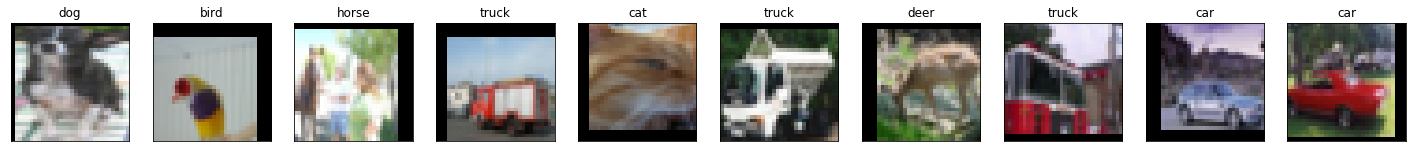

In [8]:
# obtain one batch of imges from train dataset
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in one batch with the corresponding labels
fig = plt.figure(figsize = (25, 4))

# display images
for idx in np.arange(10):
    ax = fig.add_subplot(1, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

## 4. Build Convolutional Neural Network
Those terms are used in the CNN.
- Convolution
- Channel
- Filter (Kernel)
- Stride
- Padding
- Pooling Layer <br/>
<br> 1. Convolution </br>
<br> The below image describes effectively process of Convolution.
<img src = "./Images/CNN_kernel.gif">
<br> 2. Channel </br>
<br> Color images consists of 3 channels - RGB - Red, Green and Blue. Black and White images consists of 1 channel - Black and white. For example, if the color image's height and width is 200 pixel and 400 pixel respectively, its shape is (200, 400, 3). If the black and white image's height and width is 400 pixel and 600 pixel respectively, its shape is (400, 600, 1). </br>
<br> </br>
<br> 3. Filter </br>
<br> It is a global parameter that is used to extract features in an image. It is also called a 'kernel'. It is typically a square, 3x3 or 5x5. In the above image, it is a 3x3 yellow matrix. It has numerous different types, identity, edge detection, sharpen, gaussian blur filter and so on.
<br> </br>
<br> 4. Stride </br>
<br> Filter calculates the convolution by iterating over the input data at specific intervals. Thus, the number of pixels shifts over the input matrix is called Stride. </br>
<br> </br>
<br> 5. Padding </br>
<br> Padding prevents a reduction of output layer of Convolutional layer. It means filling outer pixels of input images with a specific value. </br>
<br> </br>
<br> 6. Pooling layer </br>
<br> Its main purpose is to reduce the size of the ouput data or to emphasize the specific pattern. Mainly there are max pooling and average pooling, the below image helps the understanding.
<img src = "./Images/Pooling.png" height = "300px" width = "400px">
It is also very important to know how to calculate the feature map size. Let output size `O`, input size `N`, padding `P`, filter (or kernel) `F`, stride `S`. Then, the equation becomes `O = (N+2P-F)/S + 1`. If its result is not an integer but a float, the computer automatically conducts round down. <br/>
<br> Using the concepts aforementioned, we can develop our own convolutional neural network architecture that aims to classify CIFAR10 dataset. </br>

In [9]:
# define the CNN architecture

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.main = nn.Sequential(
            # 3x32x32
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1), # 3x32x32 (O = (N+2P-F/S)+1)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size = 2, stride = 2), # 32x16x16
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 64, kernel_size = 3, padding = 1), # 32x16x16
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), # 64x8x8
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 128, 3, padding = 1), # 64x8x8
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), # 128x4x4
            nn.BatchNorm2d(128),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128*4*4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            
            nn.Linear(256, 10)
        )
        
    def forward(self, x):
        # Conv and Poolilng layers
        x = self.main(x)
        
        # Flatten before Fully Connected layers
        x = x.view(-1, 128*4*4) 
        
        # Fully Connected Layer
        x = self.fc(x)
        return x

In [10]:
# printout information on CNN architecture

cnn = CNN().to(device)
cnn

CNN(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=2048, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, in

`torch.nn.CrossEntropyLoss` is used to for the classification model whose output is a probability between 0 and 1. 
`torch.optim.Adam` is used as it shows the best performance so far.

In [11]:
# Hyper Parameters
learning_rate = 0.001
train_losses = []
val_losses = []

# Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr = learning_rate)

## 5. Train the Model

In [12]:
# define train function that trains the model using a CIFAR10 dataset

def train(model, epoch, num_epochs):
    model.train()
    
    total_batch = len(train_dataset) // batch_size
    
    for i, (images, labels) in enumerate(train_loader):
            
        X = images.to(device)
        Y = labels.to(device)

        ### forward pass and loss calculation
        # forward pass
        pred = model(X)
        #c alculation  of loss value
        cost = criterion(pred, Y)

        ### backward pass and optimization
        # gradient initialization
        optimizer.zero_grad()
        # backward pass
        cost.backward()
        # parameter update
        optimizer.step()
            
        # training stats
        if (i+1) % 100 == 0:
            print('Train, Epoch [%d/%d], lter [%d/%d], Loss: %.4f' 
                  % (epoch+1, num_epochs, i+1, total_batch, np.average(train_losses)))
            
            train_losses.append(cost.item())

In [13]:
# def the validation function that validates the model using CIFAR10 dataset

def validation(model, epoch, num_epochs):
    model.eval()
    
    total_batch = len(val_dataset) // batch_size
    
    for i, (images, labels) in enumerate(val_loader):
        
        X = images.to(device)
        Y = labels.to(device)
        
        with torch.no_grad():
            pred = model(X)
            cost = criterion(pred, Y)
        
        if (i+1) % 100 == 0:
            print("Validation, Epoch [%d/%d], lter [%d/%d], Loss: %.4f"
                  % (epoch+1, num_epochs, i+1, total_batch, np.average(val_losses)))
            
            val_losses.append(cost.item())

In [14]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(5, 5))
    plt.plot(train_losses, label='Train', alpha=0.5)
    plt.plot(val_losses, label='Validation', alpha=0.5)
    plt.xlabel('Epochs')
    plt.ylabel('Losses')
    plt.legend()
    plt.grid(b=True)
    plt.title('CIFAR 10 Train/Val Losses Over Epoch')
    plt.show()

Train, Epoch [1/20], lter [100/390], Loss: nan
Train, Epoch [1/20], lter [200/390], Loss: 1.4725
Train, Epoch [1/20], lter [300/390], Loss: 1.3758
Validation, Epoch [1/20], lter [100/390], Loss: nan
Validation, Epoch [1/20], lter [200/390], Loss: 0.9379
Validation, Epoch [1/20], lter [300/390], Loss: 0.9114
Train, Epoch [2/20], lter [100/390], Loss: 1.3173
Train, Epoch [2/20], lter [200/390], Loss: 1.2400
Train, Epoch [2/20], lter [300/390], Loss: 1.1808
Validation, Epoch [2/20], lter [100/390], Loss: 0.9342
Validation, Epoch [2/20], lter [200/390], Loss: 0.8919
Validation, Epoch [2/20], lter [300/390], Loss: 0.8767
Train, Epoch [3/20], lter [100/390], Loss: 1.1499
Train, Epoch [3/20], lter [200/390], Loss: 1.1115
Train, Epoch [3/20], lter [300/390], Loss: 1.0732
Validation, Epoch [3/20], lter [100/390], Loss: 0.8804
Validation, Epoch [3/20], lter [200/390], Loss: 0.8540
Validation, Epoch [3/20], lter [300/390], Loss: 0.8306
Train, Epoch [4/20], lter [100/390], Loss: 1.0677
Train, Epoc

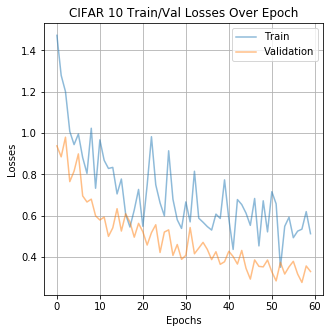

In [15]:
num_epochs = 20
for epoch in range(num_epochs):
    train(cnn, epoch, num_epochs)
    validation(cnn, epoch, num_epochs)
    torch.save(cnn.state_dict(), './data/Tutorial_3_CNN_Epoch_{}.pkl'.format(epoch+1))

plot_losses(train_losses, val_losses)

## 6. Test the Model
This neural network should be checked by comparing the class labels that it predicted against the ground-truth. If the prediction is correct, one is added to the list of correct predictions.

In [16]:
def test(model):
    
    # declare that the model is about to evaluate
    model.eval()

    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_dataset:
            images = images.unsqueeze(0).to(device)
            
            # forward pass
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            total += 1
            correct += (predicted == labels).sum().item()

    print("Accuracy of Test Images: %f %%" % (100 * float(correct) / total))

In [17]:
test(model = cnn)

Accuracy of Test Images: 83.720000 %


It is desirable to figure out on which classes the model performed well or not. 

In [18]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = cnn(images)
        
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 100 %
Accuracy of   car : 92 %
Accuracy of  bird : 72 %
Accuracy of   cat : 58 %
Accuracy of  deer : 88 %
Accuracy of   dog : 72 %
Accuracy of  frog : 77 %
Accuracy of horse : 80 %
Accuracy of  ship : 93 %
Accuracy of truck : 84 %
